# PSUPR / PRMLS CA2

### Team
Kenneth Goh Chia Wei : A0198544N  
Tan Heng Han : A0198502B  
Raymond Ng Boon Cheong : A0198543R

In [79]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import pprint
import lxml
import re
import os
import glob
from collections import Counter

from bs4 import BeautifulSoup
from nltk.tokenize import WordPunctTokenizer
from sklearn.model_selection import train_test_split

## Create a function for cleaning up tweets
Reference: https://towardsdatascience.com/another-twitter-sentiment-analysis-bb5b01ebad90

In [68]:
# Init WordPunctTokenizer
tok = WordPunctTokenizer()
# create reg expression
pat1 = r'@[A-Za-z0-9]+'
pat2 = r'https?://[A-Za-z0-9./]+'
combined_pat = r'|'.join((pat1, pat2))

def tweet_cleaner(text):
    # Use beautiful soup to decode html to text
    soup = BeautifulSoup(text, 'lxml')
    souped = soup.get_text()
    # strip text using regular expression
    stripped = re.sub(combined_pat, '', souped)
    try:
        clean = stripped.decode("utf-8-sig").replace(u"\ufffd", "?")
    except:
        clean = stripped
    # strip to letters only
    letters_only = re.sub("[^a-zA-Z]", " ", clean)
    # remove retweets handle
    removed_rt = re.sub('RT ','',letters_only)
    # set to lower case for all characters
    lower_case = removed_rt.lower()
    # During the letters_only process two lines above, it has created unnecessay white spaces,
    # I will tokenize and join together to remove unneccessary white spaces
    words = tok.tokenize(lower_case)
    return (" ".join(words)).strip()

In [70]:
dataset_directories = {
    'happy': '..\dataset\happy',
    'sad': '..\dataset\sad',
    'angry': '..\dataset\\angry',
}

def getTweetsFromCSV(directory):  
    files = glob.glob(directory + '\*.csv')
    dfs = [pd.read_csv(f) for f in files]
    dfs_combined = pd.concat(dfs, ignore_index=True)
    return dfs_combined

dfs = []
for directory in dataset_directories:
    all_dfs = getTweetsFromCSV(dataset_directories[directory])
    all_dfs['label'] = directory
    dfs.append(all_dfs)

df_col = dfs[0].columns
final = pd.concat(dfs, ignore_index=True)
df = pd.DataFrame(final, columns=df_col)

In [71]:
df.head()

,text,weekday,month,day,hour,has_hashtag,has_url,fav_count,is_reply,retweet_count,followers,following,user,screen_name,label
0,CRUSH GAME: Describe your crush\n\n1. slightly...,Thu,Sep,12,13,0,1,0,0,0,39,100,+,melliflcus,happy
1,RT @Emolclause: #BREAKING:Now we find out that...,Thu,Sep,12,13,1,0,0,0,157,280,605,Kathleen A. English,kenglishesq1,happy
2,@susie_meister Bless your heart! The neighbor ...,Thu,Sep,12,13,0,1,1,1,0,415,868,Gabrielle,DGCBcardiac96,happy
3,RT @ajimatanrareje: Wow!!! Somethings are bett...,Thu,Sep,12,13,1,1,0,0,1,122,281,Foluso John Gbadebo.,jfoluso,happy
4,@realDonaldTrump Mexico. Wall. Pay. Didn't kno...,Thu,Sep,12,13,0,1,0,1,0,44,82,Paul Gordon,NoJob1263,happy


In [72]:
text = df['text']
label = df['label']
text.head()

0    CRUSH GAME: Describe your crush\n\n1. slightly...
1    RT @Emolclause: #BREAKING:Now we find out that...
2    @susie_meister Bless your heart! The neighbor ...
3    RT @ajimatanrareje: Wow!!! Somethings are bett...
4    @realDonaldTrump Mexico. Wall. Pay. Didn't kno...
Name: text, dtype: object

In [73]:
label.head()

0    happy
1    happy
2    happy
3    happy
4    happy
Name: label, dtype: object

### Clean up all tweets

In [94]:
cleaned_tweets = []
for tweet in text:
    cleaned_tweets.append(tweet_cleaner(tweet))
print((cleaned_tweets[:5]))
print(f'Tweets total: {len(cleaned_tweets)}')

['crush game describe your crush slightly taller older floof noooo nooo school', 'breaking now we find out that pence needlessly cost taxpayers shuttling back and forth from dunlin to trump', 'meister bless your heart the neighbor had to sell his house and move because of all the money his stupidity', 'wow somethings are better explained visually sad', 'mexico wall pay didn t know the armed forces budget was in pesos since they ve been ordered to']
Tweets total: 13083


### Join back to a single DataFrame and remove duplicated tweets

In [95]:
finalDF = pd.DataFrame({'text': cleaned_tweets, 'label': label})
finalDF.drop_duplicates(subset='text', inplace=True, keep='first')

In [96]:
finalDF.shape

(3279, 2)

In [98]:
finalDF.head()

,text,label
0,crush game describe your crush slightly taller...,happy
1,breaking now we find out that pence needlessly...,happy
2,meister bless your heart the neighbor had to s...,happy
3,wow somethings are better explained visually sad,happy
4,mexico wall pay didn t know the armed forces b...,happy


### Display label distributions

Text(0.5, 1.0, 'Tweets Label Distro')

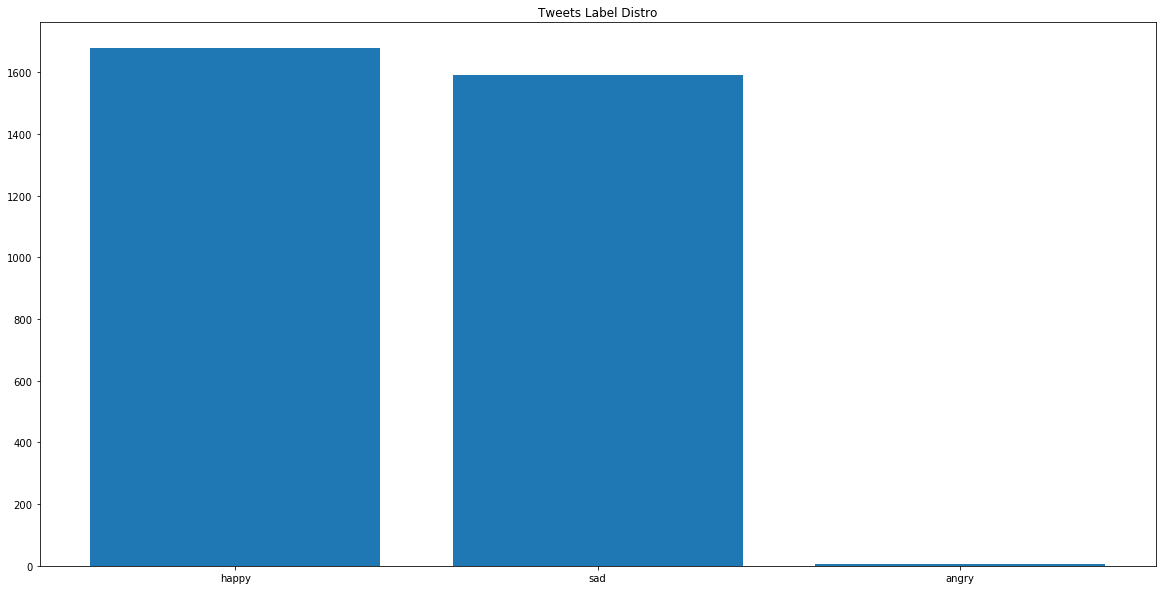

In [99]:
label_count = Counter(finalDF.label)

plt.figure(figsize=(20, 10))
plt.bar(label_count.keys(), label_count.values())
plt.title('Tweets Label Distro')

### Train, Test set split

In [103]:
X_train, X_test, y_train, y_test = train_test_split(finalDF.text, finalDF.label, test_size=0.2, random_state=42)

In [104]:
X_train.head()

321                               i e you can jo soapy sad
1322     yeah except when you referred to it as or mayb...
12132    so good i had to share check out all the items...
11929    listen to storytyme crazy dark rap instrumenta...
12063    onda wellness x dr janine mahon launch libido ...
Name: text, dtype: object

In [105]:
y_train.head()

321      happy
1322     happy
12132      sad
11929      sad
12063      sad
Name: label, dtype: object